In [73]:
import torch
from PIL import UnidentifiedImageError
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.models import vgg19

In [74]:
device = "cuda"

In [75]:
# Custom Dataset with Error Handling
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super(SafeImageFolder, self).__getitem__(index)
        except (UnidentifiedImageError, IOError, OSError) as e:
            # print(f"Skipping invalid image at index {index}: {e}")
            return None

In [76]:
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)


In [77]:
# Define the dataset path
dataset_path = "/kaggle/input/art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated"

# Define transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [78]:
# Load training and validation datasets
train_dataset = SafeImageFolder(root=f"{dataset_path}/training_set", transform=transform)
val_dataset = SafeImageFolder(root=f"{dataset_path}/validation_set", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=safe_collate)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=safe_collate)

# Print dataset details
print(f"Classes: {train_dataset.classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Example: Iterate through training data
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


Classes: ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
Number of training samples: 7819
Number of validation samples: 866
torch.Size([127, 3, 224, 224]) torch.Size([127])


In [89]:
model = vgg19(pretrained=True)

In [90]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [91]:
# override last layers
num_classes = len(train_dataset.classes)
print("Number of class: ",num_classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

Number of class:  5


In [92]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# sm = nn.Softmax(dim=1) 

In [94]:
train_loss_history = []
val_loss_history = []
val_acc_history = []
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # Freeze CNN layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Check trainable parameters
    print("Trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc="Training")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            train_bar.set_postfix(loss=(running_loss / len(train_bar)))
        
        # break
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_bar = tqdm(val_loader, desc="Validation")
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                val_bar.set_postfix(loss=(val_loss / len(val_bar)))
        
        val_accuracy = correct / total
        train_loss_history.append(running_loss/len(train_loader))
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_accuracy)
        print(f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")


In [95]:
train_model(model=model,train_loader=train_loader,val_loader=val_loader,criterion=criterion,optimizer=optimizer,num_epochs=20)

Trainable parameters:
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias
Epoch 1/20


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s, loss=0.484]


Train Loss: 1.0020, Val Loss: 0.4845, Val Accuracy: 0.8481
Epoch 2/20


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s, loss=0.31] 


Train Loss: 0.4172, Val Loss: 0.3100, Val Accuracy: 0.8879
Epoch 3/20


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s, loss=0.261]


Train Loss: 0.2913, Val Loss: 0.2611, Val Accuracy: 0.9019
Epoch 4/20


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s, loss=0.239]


Train Loss: 0.2316, Val Loss: 0.2390, Val Accuracy: 0.9112
Epoch 5/20


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s, loss=0.226] 


Train Loss: 0.1975, Val Loss: 0.2256, Val Accuracy: 0.9100
Epoch 6/20


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s, loss=0.216] 


Train Loss: 0.1587, Val Loss: 0.2161, Val Accuracy: 0.9159
Epoch 7/20


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.17it/s, loss=0.211] 


Train Loss: 0.1349, Val Loss: 0.2112, Val Accuracy: 0.9171
Epoch 8/20


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s, loss=0.204] 


Train Loss: 0.1158, Val Loss: 0.2040, Val Accuracy: 0.9217
Epoch 9/20


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s, loss=0.203] 


Train Loss: 0.0983, Val Loss: 0.2027, Val Accuracy: 0.9194
Epoch 10/20


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s, loss=0.203] 


Train Loss: 0.0798, Val Loss: 0.2030, Val Accuracy: 0.9229
Epoch 11/20


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s, loss=0.201] 


Train Loss: 0.0666, Val Loss: 0.2012, Val Accuracy: 0.9241
Epoch 12/20


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s, loss=0.204] 


Train Loss: 0.0551, Val Loss: 0.2039, Val Accuracy: 0.9217
Epoch 13/20


Validation: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s, loss=0.205] 


Train Loss: 0.0479, Val Loss: 0.2049, Val Accuracy: 0.9241
Epoch 14/20


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s, loss=0.206] 


Train Loss: 0.0389, Val Loss: 0.2057, Val Accuracy: 0.9252
Epoch 15/20


Training:   5%|▍         | 3/62 [00:03<01:01,  1.04s/it, loss=0.00173] 


KeyboardInterrupt: 

In [96]:
import matplotlib.pyplot as plt

In [97]:
train_loss_history

[1.0019644811268775,
 0.4172083784735972,
 0.2912953414263264,
 0.2315776028460072,
 0.19754554836019392,
 0.15866422970148344,
 0.13492796389806655,
 0.11581965535879135,
 0.0982898136060084,
 0.07978551071738044,
 0.06663551071899072,
 0.0550826202417093,
 0.047876249097527995,
 0.03893741921732022]

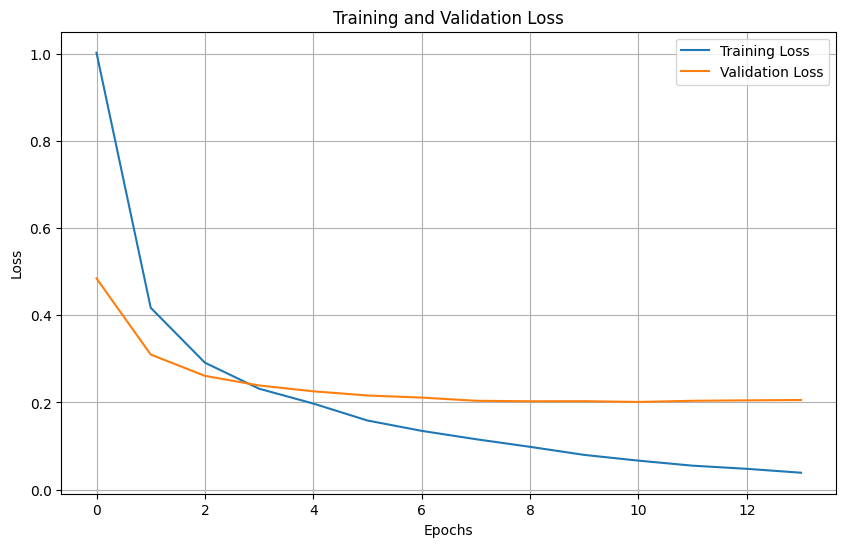

In [98]:
# Assuming train_history and val_history are updated during the training loop
def plot_loss(train_history, val_history):
    plt.figure(figsize=(10, 6))
    plt.plot(train_history, label='Training Loss')
    plt.plot(val_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train_loss_history, val_loss_history)


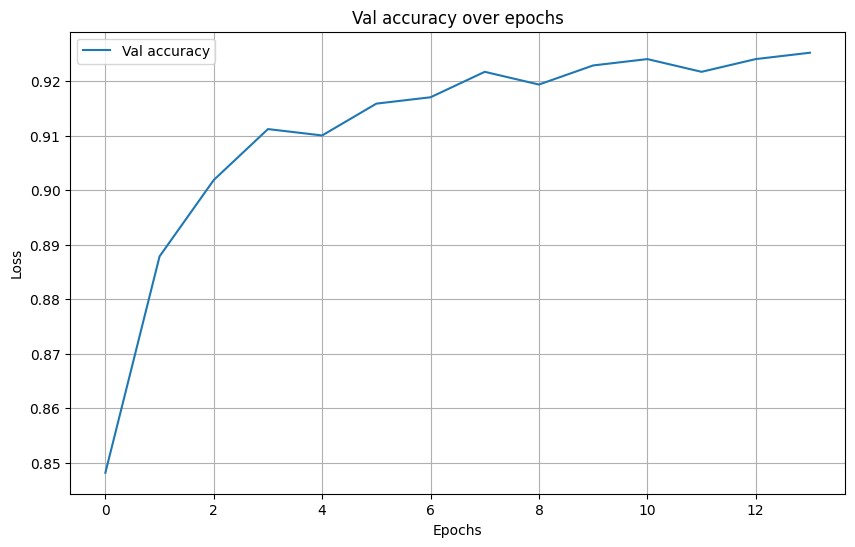

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(val_acc_history, label='Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val accuracy over epochs')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
torch.save(model.state_dict(), "/kaggle/working/model.pth")

In [101]:
from torchvision.utils import make_grid

In [102]:
def visualize_weights(weights, num_columns=8, title="Model Weights"):
    """
    Visualize weights as an image grid.
    Args:
        weights (torch.Tensor): Weights tensor of shape (num_filters, C, H, W).
        num_columns (int): Number of columns in the grid.
        title (str): Title of the plot.
    """
    # Normalize weights for visualization
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    grid = make_grid(weights, nrow=num_columns, normalize=True, padding=1)
    
    # Convert to numpy and plot
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Convert to HWC format for plotting
    plt.title(title)
    plt.axis('off')
    plt.show()


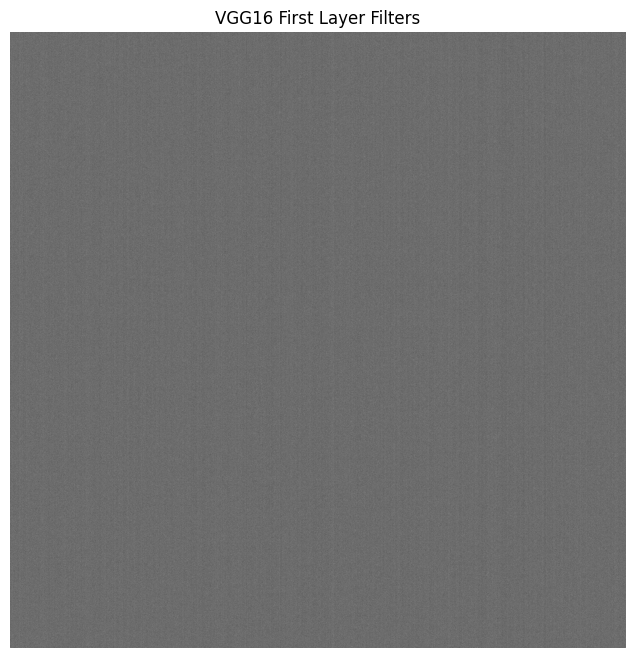

In [103]:
# Extract first convolutional layer weights
first_layer_weights = model.classifier[3].weight.data.clone().cpu()

# Visualize weights
visualize_weights(first_layer_weights, num_columns=8, title="VGG16 First Layer Filters")
